In [4]:
import os
%env OPENAI_API_KEY=token
%env REPLICATE_API_TOKEN=token

print(os.environ.get("OPENAI_API_KEY"))

env: OPENAI_API_KEY=token
env: REPLICATE_API_TOKEN=token
token


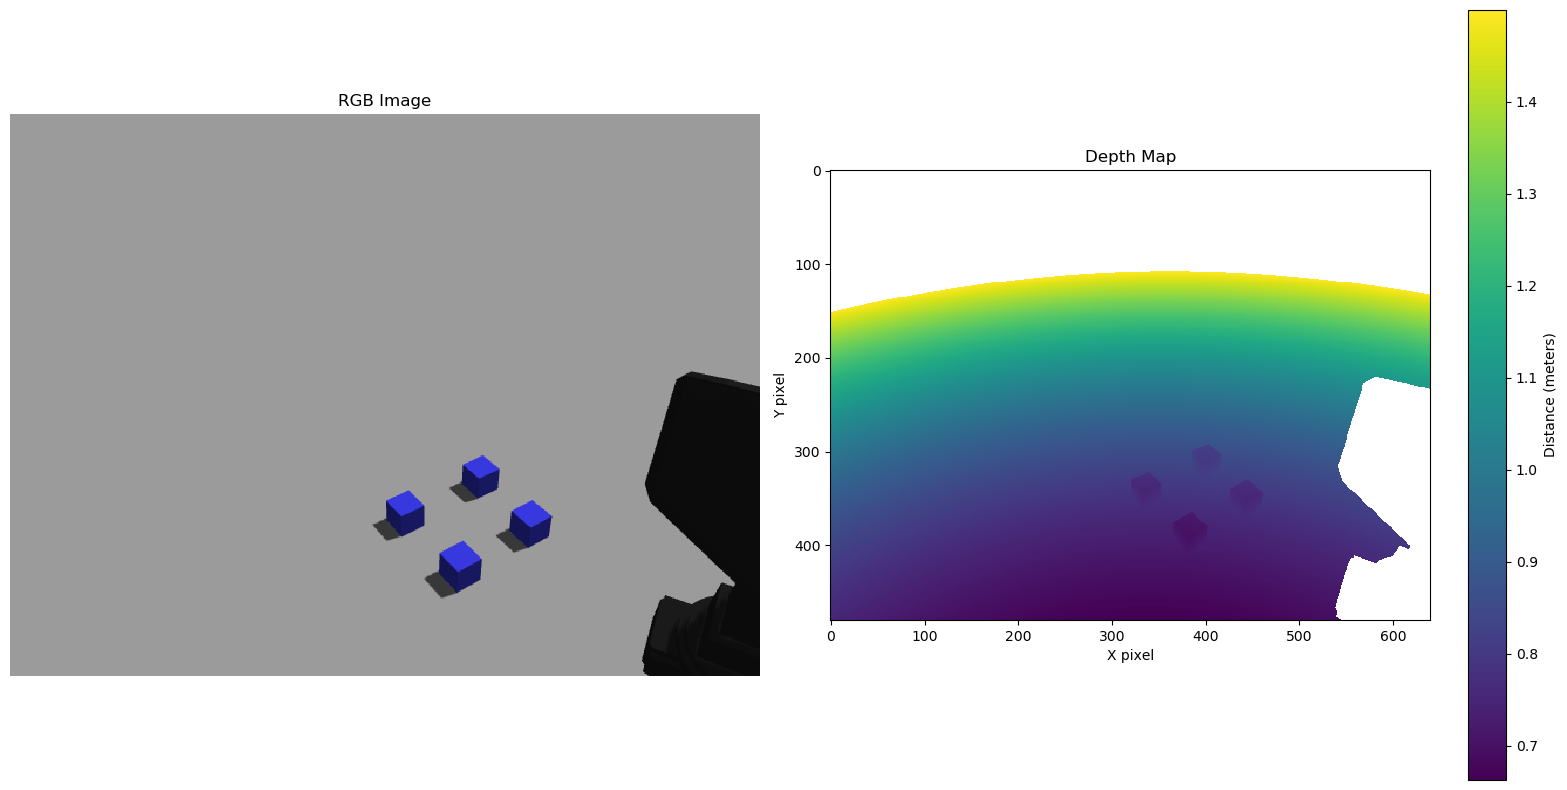

Using OpenAI API with model gpt-4o
Sending prompt to OpenAI...
Base response received.
To construct the house-like structure with a square base and a triangular roof, we'll follow these steps:

### Structure Breakdown

1. **Base:** A square structure occupying coordinates (3,1) to (7,5).
2. **Roof:** A triangular shape sitting on top of the square from coordinates (3,5) to (7,8), with the top point at (5,8).

Now, let's move the blocks step by step:

### Step-by-Step Instructions

#### Blocks in Current Environment
Let's label the blocks:
- Bottom Left: (0,0)
- Bottom Right: (1,0)
- Top Left: (0,1)
- Top Right: (1,1)

#### Steps

1. **Action 1**: 
   - `{ pos_init : {x:0, y:0}, pos_finale : {x:3, y:1}, notice : 'Place the bottom-left corner of the base.' }`

2. **Action 2**: 
   - `{ pos_init : {x:1, y:0}, pos_finale : {x:7, y:1}, notice : 'Place the bottom-right corner of the base.' }`

3. **Action 3**: 
   - `{ pos_init : {x:0, y:1}, pos_finale : {x:5, y:5}, notice : 'Place the top p

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from visioncraft.locobot.camera import LocobotCamera
import rospy
from visioncraft.vlm.vlm_pipeline import VLMPipeline
import os

def visualize_depth_map(cam, min_distance=0.5, max_distance=1.5):
    """
    Create a depth map visualization and show the RGB image using matplotlib
    """
    # Get the image
    img = cam.get_image()
    if img is None:
        print("No image received")
        return
        
    height, width = img.shape[:2]
    
    # Create depth map
    depth_map = np.full((height, width), np.nan)
    
    # Fill depth map with distances
    for y in range(height):
        for x in range(width):
            point = cam.get_point_at_pixel(x, y)
            if point is not None:
                # Calculate distance from camera (Euclidean distance)
                distance = np.sqrt(point[0]**2 + point[1]**2 + point[2]**2)
                if min_distance <= distance <= max_distance:
                    depth_map[y, x] = distance  # Only keep valid distances
    
    # Create visualization
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot RGB image
    axs[0].imshow(img)
    axs[0].set_title('RGB Image')
    axs[0].axis('off')
    

    # Plot depth map
    depth_plot = axs[1].imshow(depth_map, cmap='viridis')
    axs[1].set_title('Depth Map')
    axs[1].set_xlabel('X pixel')
    axs[1].set_ylabel('Y pixel')
    fig.colorbar(depth_plot, ax=axs[1], label='Distance (meters)')
    
    plt.tight_layout()
    plt.show()

def get_depth_map(cam, min_distance=0.5, max_distance=1.5):
    """
    Get the depth map from the camera
    """
    # Get the image
    img = cam.get_image()
    if img is None:
        print("No image received")
        return
        
    height, width = img.shape[:2]
    
    # Create depth map
    depth_map = np.full((height, width), np.nan)
    
    # Fill depth map with distances
    for y in range(height):
        for x in range(width):
            point = cam.get_point_at_pixel(x, y)
            if point is not None:
                # Calculate distance from camera (Euclidean distance)
                distance = np.sqrt(point[0]**2 + point[1]**2 + point[2]**2)
                if min_distance <= distance <= max_distance:
                    depth_map[y, x] = distance  # Only keep valid distances
    
    return depth_map, height, width

def pick_block_action(action, cam):
    print(f"Action: {action}")
    pos_init = action['pos_init']
    depth_map, height, width = get_depth_map(cam)
    x = int(pos_init["x"]/100 * width)
    y = int(pos_init["y"]/100 * height)
    print(f"X: {x}, Y: {y}")
    if depth_map[y, x] is not None:
        print(f"Distance: {depth_map[y, x]} m")
    else:
        print("No valid distance found at this pixel.")

def place_block_action(action, cam):
    print(f"Action: {action}")
    pass

def main():
    cam = LocobotCamera()
    cam.pan(0.5)
    cam.tilt(0.6)
    img = cam.get_image()
        
    # Visualize depth map and image
    visualize_depth_map(cam)
    plt.imsave('../resources/rgb_image.png', img)

    vlm_pipeline = VLMPipeline(model_name="gpt-4o", openai_api_key=os.environ.get("OPENAI_API_KEY"))
    vlm_pipeline.set_current_image("../resources/rgb_image.png")
    vlm_pipeline.set_goal_image("../resources/simple_house.png")
    json_answer = vlm_pipeline.run_pipeline()
    for actions in json_answer:
            for action in json_answer[actions]:
                # Each action to accomplish
                pick_block_action(action, cam)
                

    # Wait for some data to be received
    rospy.sleep(1.0)


if __name__ == '__main__':
    main()
